In [1]:
import pylab as pl
import pandas as pd
import numpy as np
#imports downloader
import scipy.stats


from __future__ import print_function, division

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

import statsmodels.api as sm
import statsmodels.formula.api as smf


%pylab inline
import json
import os, shutil
import sys
import requests

Populating the interactive namespace from numpy and matplotlib


In [4]:
TXdata = pd.read_csv("https://stacks.stanford.edu/file/druid:py883nd2578/TX-clean.csv.gz", index_col = None, compression = 'gzip')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,16,19,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
## Drop columns not needed

TXdataTrim = TXdata.drop([u'state', u'county_fips', u'fine_grained_location', 
       u'police_department', u'driver_gender', u'driver_age_raw',
       u'driver_age', u'violation_raw',
       u'violation', u'lat', u'lon',
       u'officer_id'], axis=1)

In [11]:
TXcrs = TXdataTrim.groupby(['county_name', 'driver_race','search_conducted']).count()

In [12]:
TXcrs.drop([u'stop_date', u'stop_time', u'location_raw', u'driver_race_raw',
       u'search_type_raw', u'search_type', u'contraband_found',
       u'stop_outcome', u'is_arrested', u'driver_race_original'],axis=1, inplace=True)

In [13]:
TXsearch = TXcrs

In [14]:
TXcontraband = TXdataTrim[TXdataTrim.search_conducted == True] 
TXcontraband = TXcontraband.groupby(['county_name', 'driver_race','contraband_found']).count()
TXcontraband.drop([u'stop_date', u'stop_time', u'location_raw', u'driver_race_raw',
       u'search_type_raw', u'search_type', u'search_conducted',
       u'stop_outcome', u'is_arrested', u'driver_race_original'],axis=1, inplace=True)

In [15]:
TXcontraband.head(10)

id
county_name     driver_race contraband_found     
Anderson County Black       False             210
                            True              136
                Hispanic    False             152
                            True               77
                Other       False               2
                White       False             737
                            True              405
Andrews County  Asian       False               1
                            True                1
                Black       False              27

In [16]:
TXsearch.head(10)

id
county_name     driver_race search_conducted       
Anderson County Asian       False               638
                Black       False             18504
                            True                346
                Hispanic    False             10699
                            True                229
                Other       False               138
                            True                  2
                White       False             87781
                            True               1142
Andrews County  Asian       False               119

In [31]:
counties = TXsearch.index.get_level_values(0).unique()

In [77]:
test = TXsearch

In [123]:
blacksearchHR = {}
whitesearchHR = {}
hispanicsearchHR = {}
for county in counties:
    if len(test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Black') & \
                            (test.index.get_level_values(2) == True)]['id']) < 1:
        blacksearchHR[county] = 0
    else:
        blacksearchHR[county] = 1-((test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Black') & \
                                (test.index.get_level_values(2) == False)]['id'][0]) / \
        (test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Black') & (test.index.get_level_values(2) == False)]['id'][0] + \
    test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Black') & (test.index.get_level_values(2) == True)]['id'][0]))
    
    
    if len(test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'White') & \
                            (test.index.get_level_values(2) == True)]['id']) == 0:
        WhitesearchHR[county] = 0
    else:
        whitesearchHR[county] = 1-((test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'White') & \
                                (test.index.get_level_values(2) == False)]['id'][0]) / \
        (test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'White') & (test.index.get_level_values(2) == False)]['id'][0] + \
    test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'White') & (test.index.get_level_values(2) == True)]['id'][0]))
    
    
    if len(test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Hispanic') & \
                            (test.index.get_level_values(2) == True)]['id']) == 0:
        hispanicsearchHR[county] = 0
    else:
        hispanicsearchHR[county] = 1-((test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Hispanic') & \
                                (test.index.get_level_values(2) == False)]['id'][0]) / \
        (test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Hispanic') & (test.index.get_level_values(2) == False)]['id'][0] + \
    test[(test.index.get_level_values(0) == county) & (test.index.get_level_values(1) == 'Hispanic') & (test.index.get_level_values(2) == True)]['id'][0]))
    

In [134]:
blackcontrabandHR = {}
whitecontrabandHR = {}
hispaniccontrabandHR = {}
for county in counties:
    if len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) < 1:
        blackcontrabandHR[county] = 0
    elif len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) < 1 and\
    len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1:
        blackcontrabandHR[county] = np.nan()
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        blackcontrabandHR[county] = 1
    
    else:
        blackcontrabandHR[county] = 1-((TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & \
                                (TXcontraband.index.get_level_values(2) == False)]['id'][0]) / \
        (TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & (TXcontraband.index.get_level_values(2) == False)]['id'][0] + \
    TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Black') & (TXcontraband.index.get_level_values(2) == True)]['id'][0]))
    
    
    if len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) == 0:
        whitecontrabandHR[county] = 0
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) < 1) &\
    (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        whitecontrabandHR[county] = np.nan()
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        whitecontrabandHR[county] = 1
    else:
        whitecontrabandHR[county] = 1-((TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & \
                                (TXcontraband.index.get_level_values(2) == False)]['id'][0]) / \
        (TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & (TXcontraband.index.get_level_values(2) == False)]['id'][0] + \
    TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'White') & (TXcontraband.index.get_level_values(2) == True)]['id'][0]))
    
    
    if len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) == 0:
        hispaniccontrabandHR[county] = 0
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & \
                            (TXcontraband.index.get_level_values(2) == True)]['id']) < 1) &\
    (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        hispaniccontrabandHR[county] = np.nan()
        
        
    elif (len(TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & \
                            (TXcontraband.index.get_level_values(2) == False)]['id']) < 1):
        blackcontrabandHR[county] = 1
        
    else:
        hispaniccontrabandHR[county] = 1-((TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & \
                                (TXcontraband.index.get_level_values(2) == False)]['id'][0]) / \
        (TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & (TXcontraband.index.get_level_values(2) == False)]['id'][0] + \
    TXcontraband[(TXcontraband.index.get_level_values(0) == county) & (TXcontraband.index.get_level_values(1) == 'Hispanic') & (TXcontraband.index.get_level_values(2) == True)]['id'][0]))
    

In [161]:
bcHRvals = np.asarray(list(blackcontrabandHR.values()))
wcHRvals = np.asarray(list(whitecontrabandHR.values()))
hcHRvals = np.asarray(list(hispaniccontrabandHR.values()))
bsHRvals = np.asarray(list(blacksearchHR.values()))
wsHRvals = np.asarray(list(whitesearchHR.values()))
hsHRvals = np.asarray(list(hispanicsearchHR.values()))

In [189]:
sizesS = []
sizesC = []
for county in counties:
    sizesC.append(10000*(TXcontraband[TXcontraband.index.get_level_values(0) == county]['id'].sum()/TXcontraband['id'].sum()))
    sizesS.append(10000*(TXsearch[TXsearch.index.get_level_values(0) == county]['id'].sum()/TXsearch['id'].sum()))

Text(0,0.5,'Rate of Contraband Recovery in Search (Race = Black)')

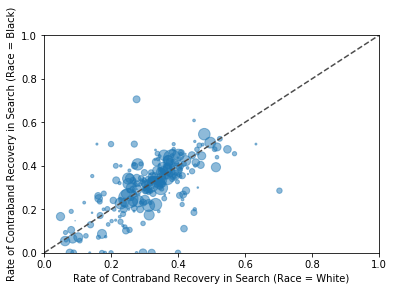

In [190]:
plt.scatter(wcHRvals, bcHRvals, alpha=.5, s=sizesC)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlabel("Rate of Contraband Recovery in Search (Race = White)")
plt.ylabel("Rate of Contraband Recovery in Search (Race = Black)")

Text(0,0.5,'Rate of Contraband Recovery in Search (Race = Hispanic)')

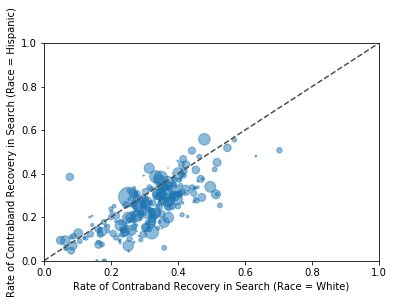

In [191]:
plt.scatter(wcHRvals, hcHRvals, alpha = .5, s=sizesC)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlabel("Rate of Contraband Recovery in Search (Race = White)")
plt.ylabel("Rate of Contraband Recovery in Search (Race = Hispanic)")

Text(0,0.5,'Rate of Search after Stop (Race = Black)')

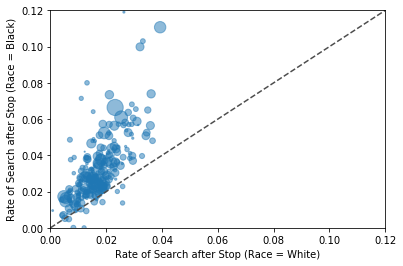

In [195]:
plt.scatter(wsHRvals, bsHRvals, alpha = .5, s=sizesS)
plt.xlim([0,.12])
plt.ylim([0,.12])
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlabel("Rate of Search after Stop (Race = White)")
plt.ylabel("Rate of Search after Stop (Race = Black)")

Text(0,0.5,'Rate of Search after Stop (Race = Hispanic)')

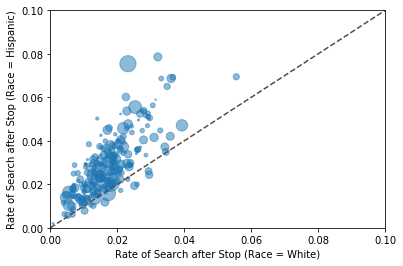

In [193]:
plt.scatter(wsHRvals, hsHRvals, alpha = .5, s=sizesS)
plt.xlim([0,.1])
plt.ylim([0,.1])
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlabel("Rate of Search after Stop (Race = White)")
plt.ylabel("Rate of Search after Stop (Race = Hispanic)")